## 导入相关工具和库

In [1]:
!pip install tensorflow

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 8.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 813.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 2.5 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 14.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB

In [2]:
# 基本工具
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
import collections
from tqdm import tqdm
# 图像相关
import cv2
from PIL import Image

# 从 sklearn 中加载必要的库
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,accuracy_score,recall_score,classification_report

# 加载用于 CNN 的 keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from scipy.stats import shapiro
from scipy.stats import norm
import scipy.stats

2024-11-08 07:06:06.835370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-08 07:06:07.480094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 处理数据集

In [3]:
# 调整图像大小至32x32x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3
NUM_CATEGORIES = 43

In [4]:
x_train = []
y_train = []

for i in range(NUM_CATEGORIES):
    path = '/openbayes/input/input0/Train' + '//' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            # 使用PIL来打开图像
            img_path = path + '//' + img
            image = Image.open(img_path)  # 使用PIL读取图像
            image = image.convert('RGB')  # 确保转换为RGB模式
            image_resize = image.resize((IMG_HEIGHT, IMG_WIDTH))  # 调整图像大小
            x_train.append(np.array(image_resize))
            y_train.append(i)
        except:
            print("ERROR IN " + img)

# 将列表改为 numpy 数组
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape,y_train.shape)

(40604, 32, 32, 3) (40604,)


In [5]:
# 设置随机种子
np.random.seed(42)
# 打乱数据
shuffle_indexes = np.arange(x_train.shape[0])
np.random.shuffle(shuffle_indexes)
x_train = x_train[shuffle_indexes]
y_train = y_train[shuffle_indexes]
# 为CNN模型所用数据划分训练集和验证集
x_train, x_val1, y_train, y_val1 = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
print(x_train.shape,y_train.shape)
print(x_val1.shape,y_val1.shape)

(30453, 32, 32, 3) (30453,)
(10151, 32, 32, 3) (10151,)


In [6]:
# 继续扩充验证集
path = '/openbayes/input/input0/Val'
images = os.listdir(path)
x_val2 = []
y_val2 = []
for img in images:
    try:
        img_path = os.path.join(path, img)
        image = Image.open(img_path)
        image = image.convert('RGB')  # 确保转换为RGB模式
        image_resize = image.resize((IMG_HEIGHT, IMG_WIDTH))  # 调整图像大小
        x_val2.append(np.array(image_resize))  # 加入到数据集中
        # 提取标签部分
        parts = img.split('_')
        y_val2.append(int(parts[1].split('.png')[0]))    # 提取文件名中的标签
    except Exception as e:
        print(f"ERROR IN {img}: {e}")

# 将列表改为 numpy 数组
x_val2 = np.array(x_val2)
y_val2 = np.array(y_val2)
print(x_val2.shape,y_val2.shape)

(940, 32, 32, 3) (940,)


In [7]:
# 合并验证集
x_val = np.concatenate((x_val1, x_val2), axis=0)
y_val = np.concatenate((y_val1, y_val2), axis=0)
print(x_val.shape, y_val.shape)

(11091, 32, 32, 3) (11091,)


In [8]:
# 独热编码
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

y_train.shape (30453, 43)
y_valid.shape (11091, 43)


In [9]:
#准备测试集
test = pd.read_csv('/openbayes/input/input0/Test.csv')
y_test1 = test["ClassId"].values
imgs = test["Path"].values
x_test1 =[]

for img in imgs:
    try:
        # 使用PIL来打开图像
        img_path = os.path.join('/openbayes/input/input0', img)
        image = Image.open(img_path)  # 使用PIL读取图像
        image = image.convert('RGB')  # 确保转换为RGB模式
        image_resize = image.resize((IMG_HEIGHT, IMG_WIDTH))  # 调整图像大小
        x_test1.append(np.array(image_resize))
    except:
        print("Error in " + img)

x_test1 = np.array(x_test1)
y_test1 = np.array(y_test1)
print(x_test1.shape,y_test1.shape)

(12630, 32, 32, 3) (12630,)


In [10]:
#继续扩充测试集
path = '/openbayes/input/input0/Test2'
images = os.listdir(path)
x_test2= []
y_test2 = []
for img in images:
    try:
        img_path = os.path.join(path, img)
        image = Image.open(img_path)
        image = image.convert('RGB')  # 确保转换为RGB模式
        image_resize = image.resize((IMG_HEIGHT, IMG_WIDTH))  # 调整图像大小
        x_test2.append(np.array(image_resize))  # 加入到数据集中
        # 提取标签部分
        parts = img.split('_')
        y_test2.append(int(parts[1].split('.png')[0]))  # Convert string labels to integers
    except Exception as e:
        print(f"ERROR IN {img}: {e}")

# 将列表改为 numpy 数组
x_test2 = np.array(x_test2)
y_test2 = np.array(y_test2)
print(x_test2.shape,y_test2.shape)

(126, 32, 32, 3) (126,)


In [11]:
# 合并测试集
x_test = np.concatenate((x_test1, x_test2), axis=0)
y_test = np.concatenate((y_test1, y_test2), axis=0)
print(x_test.shape, y_test.shape)

(12756, 32, 32, 3) (12756,)


In [12]:
# 归一化
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

## 获取CNN模型并计算性能

In [13]:
# 获取原始模型模型
model = load_model('/openbayes/input/input1/cnn.h5')
cnn_pred = model.predict(x_test)
y_cnn_pred = np.argmax(cnn_pred, axis=-1)


# 统计precision,recall,f1_score,accuracy
precision_cnn = precision_score(y_test, y_cnn_pred,average='macro')
print('Test Data precision: ',precision_cnn)

recall_cnn = recall_score(y_test, y_cnn_pred,average='macro')
print('Test Data recall: ',recall_cnn)

f1_cnn = f1_score(y_test, y_cnn_pred,average='macro')
print('Test Data f1: ',f1_cnn)

acc_cnn = accuracy_score(y_test, y_cnn_pred)
print('Test Data accuracy: ',acc_cnn)

# 打印分类报告
print("Classification report for CNN classifier :\n{}".format(classification_report(y_test, y_cnn_pred)))

399/399 [==============================] - 1s 2ms/step
Test Data precision:  0.9000955163644029
Test Data recall:  0.8936996538803077
Test Data f1:  0.8942741739249047
Test Data accuracy:  0.9236437754782063
Classification report for CNN classifier :
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        60
           1       0.83      0.95      0.89       721
           2       0.96      0.91      0.93       752
           3       0.94      0.93      0.94       452
           4       0.95      0.90      0.92       671
           5       0.89      0.88      0.88       636
           6       0.99      0.81      0.89       156
           7       0.93      0.88      0.91       453
           8       0.93      0.96      0.94       474
           9       0.96      0.99      0.97       481
          10       0.99      0.97      0.98       683
          11       0.95      0.94      0.94       420
          12       0.95      0.95      0.95   

## 模型微调

In [14]:
class TrafficSignEnv:
    def __init__(self,model,x_train,y_train,x_val,y_val,output_file):
        # 初始化模型和数据
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.output_file = output_file
        
        # 输入模型的倒数第二个全连接层的权重
        self.dense_layer = self.model.get_layer(index=-2)
        self.w = self.dense_layer.get_weights()[0]
        self.b = self.dense_layer.get_weights()[1]
        # 打印第1个w和b
        self.print_to_file("w:{}     b:{}".format(self.w[0], self.b[0]))
        # 一次fit所需样本
        self.batch_size = 32
        self.batch_x,self.batch_y= self.sample_batch(self.x_train, self.y_train, self.batch_size)

    def print_to_file(self, text):
        with open(self.output_file, "a") as file:  # 以追加模式打开文件
            file.write(text + "\n")  # 写入内容并换行
            
    def reset(self):  # 重置即重新定位到任意索引的图片
        self.batch_x,self.batch_y= self.sample_batch(self.x_train, self.y_train, self.batch_size)
        return self.batch_x
    
    
    def step(self, action): 

        # 在验证集上的旧loss,accuracy
        old_loss,old_accuracy = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        self.print_to_file("old_loss: {}   old_accuracy: {}".format(old_loss, old_accuracy))
        

        # 调整第一个全连接层的权重
        new_w = action[0]*self.w+action[1]
        new_b = action[0]*self.b+action[1]
        self.dense_layer.set_weights([new_w, new_b])
        # 打印w和b
        self.print_to_file("w:{}     b:{}".format(new_w[0],new_b[0]))
        # fit
        self.model.fit(self.batch_x, self.batch_y,verbose=0)   
        # 在验证集上的新loss,accuracy
        new_loss, new_accuracy = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        self.print_to_file("new_loss: {}   new_accuracy: {}".format(new_loss, new_accuracy))
        # 计算奖励
        reward = self.get_reward(old_loss, new_loss, old_accuracy, new_accuracy)
        # 获取下一个状态
        self.batch_x,self.batch_y= self.sample_batch(self.x_train, self.y_train, self.batch_size)
        next_state = self.batch_x
        
        # 当前step的action以及获得的reward
        self.print_to_file("action:{}   reward:{}".format(action, reward))
        return reward,next_state

    def get_reward(self, old_loss, new_loss, old_accuracy, new_accuracy):
        loss_reward = 0
        accuracy_reward = 0
        # 计算针对准确率的奖励
        if new_accuracy > old_accuracy:
            if new_accuracy > 0.95:
                accuracy_reward = 3.0
            elif new_accuracy > 0.9:
                accuracy_reward = 2.0
            elif new_accuracy > 0.85:
                accuracy_reward = 1.0
            elif new_accuracy > 0.8:
                accuracy_reward = -1.0
            elif new_accuracy > 0.6:
                accuracy_reward = -2.0
            else:
                accuracy_reward = -3.0
        else:
            accuracy_reward = -3.0
        # 计算针对损失的奖励     
        if new_loss < old_loss:
            if new_loss < 0.1:
                loss_reward = 3.0
            elif new_loss < 0.5:
                loss_reward = 2.0
            elif new_loss < 1:
                loss_reward = 1.0
            elif new_loss < 5:
                loss_reward = -1.0
            elif new_loss < 10:
                loss_reward = -2.0
            else:
                loss_reward = -3.0
        else:
            loss_reward = -3.0
            
        return loss_reward + accuracy_reward



    # action取值范围是[-1, 1]的二维浮点数
    def sample_action(self):
        return np.random.uniform(-1, 1, size=(1,2))

    
    # 随机sample一个batch
    def sample_batch(self,x_train, y_train, batch_size):
        indices = np.random.choice(len(x_train), batch_size, replace=False)
        batch_x = x_train[indices]
        batch_y = y_train[indices]
        return batch_x, batch_y

In [15]:
# Trick 8: orthogonal initialization
def orthogonal_init(layer, gain=1.0):
    nn.init.orthogonal_(layer.weight, gain=gain)
    nn.init.constant_(layer.bias, 0)

In [16]:
## 策略网络，用于采取行动
class PolicyNet(torch.nn.Module):
    def __init__(self,action_dim):
        super(PolicyNet,self).__init__()
        # 定义卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        # 定义全连接层
        self.fc1 = nn.Linear(64 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = torch.nn.Linear(64, action_dim)
        self.fc_std = torch.nn.Linear(64, action_dim)
        
        # 对全连接层使用正交初始化
        orthogonal_init(self.fc1)
        orthogonal_init(self.fc2)
        orthogonal_init(self.fc_mu, gain=0.01)
        orthogonal_init(self.fc_std, gain=0.01)

    def forward(self, x):
        # 卷积层
        x = F.relu(self.conv1(x))  
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # 展平
        x = x.reshape(x.size(0), -1)
        # 全连接层
        x = torch.tanh(self.fc1(x))  # Trick10: use tanh
        x = torch.tanh(self.fc2(x))
        mu = 2*torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu,std

In [17]:
# 价值网络，产生价值
class ValueNet(torch.nn.Module):
    def __init__(self):
        super(ValueNet, self).__init__()
        # 定义卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1)
        self.fc1 = torch.nn.Linear(64 * 2 * 2, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        # 对全连接层使用正交初始化
        orthogonal_init(self.fc1)
        orthogonal_init(self.fc2)
        orthogonal_init(self.fc3)
        

    def forward(self, x):
        # 卷积层
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # 展平
        x = x.reshape(x.size(0), -1)
        # 全连接层
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

In [18]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:  # 通过切片操作获得td_delta的逆序列表，使得循环从最后一个元素开始遍历。
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(np.array(advantage_list), dtype=torch.float)

In [19]:
class PPO:
    ''' PPO算法 '''
    def __init__(self, action_dim, actor_lr, critic_lr,lmbda, epochs, eps, gamma, device, output_file):
        self.actor = PolicyNet(action_dim).to(device)
        self.critic = ValueNet().to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr, eps = 1e-5)   # Trick 9: set Adam epsilon=1e-5
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr, eps = 1e-5)
        self.gamma = gamma
        self.lmbda = lmbda  
        self.action_dim = action_dim
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device
        self.output_file = output_file
        
    def take_action(self, state):
        state = torch.tensor(state, dtype=torch.float).permute(0, 3, 1, 2).to(self.device)
        mu,std = self.actor(state)
        if torch.isnan(mu).any() or torch.isnan(std).any():
            print("Detected NaN values in mu or std")
        mu = mu.mean(axis = 0,keepdims=True)  #为该批图像动作取平均值
        std = std.mean(axis = 0,keepdims=True)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        # action = torch.clamp(action, -2, 2)  # 将动作限制在 (-2, 2) 范围内
        return action.squeeze().cpu()
    
    def print_to_file(self, text):
        with open(self.output_file, "a") as file:  # 以追加模式打开文件
            file.write(text + "\n")  # 写入内容并换行
        
    def update(self, transition_dict):
        
        states = torch.tensor(np.array(transition_dict['states']),dtype=torch.float).to(self.device)
        batch_size, num_images, height, width, channels = states.shape
        # 将states形状设置为(16*32, 3, 32, 32)
        states = states.view(-1, height, width, channels).permute(0, 3, 1, 2)
        
        actions = torch.tensor(np.array(transition_dict['actions']),dtype=torch.float).to(self.device)   #(16,2) 
        # print("actions shape:", actions.shape)
        
        rewards = torch.tensor(np.array(transition_dict['rewards']),dtype=torch.float).view(-1, 1).to(self.device) #(16,1)

        #rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        
        #这里next_states没用 因为和上一个state无关,且gamma会设置为0，因为各图片之间独立同分布  
        # td_target = rewards + self.gamma * self.critic(next_states) 
        td_target = rewards
        # 计算值函数估计
        values = self.critic(states)     # 输出形状为(16*32, 1)
        values = values.view(batch_size, num_images, -1).mean(dim=1)    # 每批图像取平均，输出形状为(16, 1)
        td_delta = td_target - values
        advantage = compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        
        mu, std = self.actor(states)
        std = std.view(batch_size, num_images, -1).mean(dim=1)    # 每批图像取平均，输出形状为(16, 2)
        mu = mu.view(batch_size, num_images, -1).mean(dim=1)    # 每批图像取平均，输出形状为(16, 2) 
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)
        
        for _ in range(self.epochs):
            mu, std = self.actor(states)
            if torch.isnan(mu).any() or torch.isnan(std).any():
                print("Detected NaN values in mu or std")
            std = std.view(batch_size, num_images, -1).mean(dim=1)    # 每批图像取平均，输出形状为(16, 2)
            mu = mu.view(batch_size, num_images, -1).mean(dim=1)    # 每批图像取平均，输出形状为(16, 2)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))

            values = self.critic(states)     # 输出形状为(16*32, 1)
            values = values.view(batch_size, num_images, -1).mean(dim=1)    # 每批图像取平均，输出形状为(16, 1)
            critic_loss = torch.mean(F.mse_loss(values, td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            # 在优化器执行反向传播之前，记录初始梯度状态
            for name, param in self.actor.named_parameters():
                if param.grad is not None:
                    self.print_to_file("Before backward: {}, Grad Max: {}, Grad Mean: {}".format(name,param.grad.abs().max(),param.grad.abs().mean())) 
            actor_loss.backward()
            critic_loss.backward()
            # 在优化器更新参数之前，再次记录梯度状态
            for name, param in self.actor.named_parameters():
                if param.grad is not None:
                    self.print_to_file("After backward, Before optimizer step: {}, Grad Max: {}, Grad Mean: {}".format(name,param.grad.abs().max(),param.grad.abs().mean()))
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)# Trick 7: Gradient clip
            self.actor_optimizer.step()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)# Trick 7: Gradient clip
            self.critic_optimizer.step()

In [20]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

In [21]:
# 模型的准确率采用前五个包含标签即视为正确
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=[TopKCategoricalAccuracy(k=5)])
# 实例化环境
env = TrafficSignEnv(model, x_train, y_train, x_val, y_val,output_file = 'ouput1.txt')

In [22]:
#gamma取0,因为每个状态独立同分布  
gamma = 0
# actor网络学习率
actor_lr = 3e-4
# critic网络学习率
critic_lr = 3e-4
# 计算advantage时使用
lmbda = 0.9
# 网络更新次数
epochs = 10
# PPO截断参数
eps = 0.2
# 设备
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# 动作空间维度
action_dim = 2
# 代理
agent = PPO(action_dim, actor_lr, critic_lr,lmbda, epochs, eps, gamma, device, output_file = 'output2.txt')

In [23]:
# 总共迭代次数
epoches = 600
# 每个epoch进行16次循环
forward = 16
# 所有迭代过程中的总奖励列表
reward_list = []
for i in range(10):
    with tqdm(total=int(epoches/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(epoches/10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'rewards': []}
            state = env.reset()
            for step in range(forward):
                action = agent.take_action(state)
                reward, next_state = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(np.array(action))
                transition_dict['rewards'].append(reward)
                state = next_state
                episode_return += reward
            reward_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode+1) % 5 == 0:
                pbar.set_postfix({'episode': '%d' % (epoches/10 * i + i_episode+1), 'return': '%.3f' % np.mean(reward_list[-5:])})
            pbar.update(1)

Iteration 9: 100%|██████████| 60/60 [32:39<00:00, 32.65s/it, episode=600, return=-18.400]


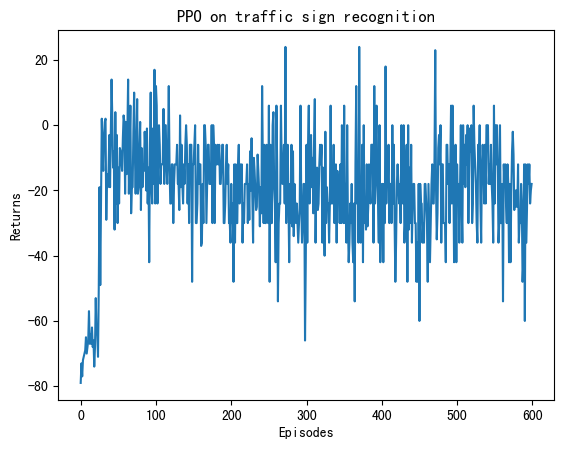

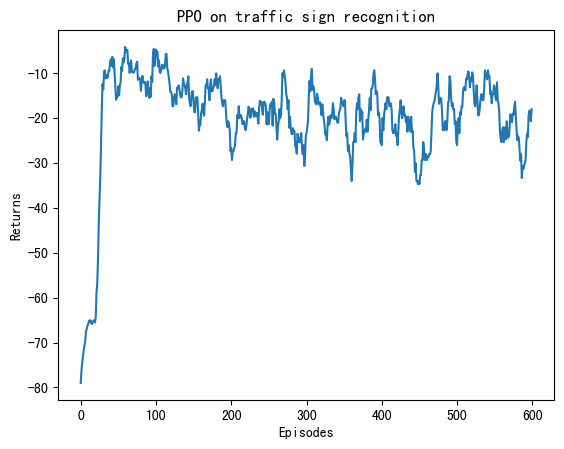

In [24]:
episodes_list = list(range(len(reward_list)))
plt.plot(episodes_list, reward_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format("traffic sign recognition"))
plt.show()
 
mv_return = moving_average(reward_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format("traffic sign recognition"))
plt.show()

In [25]:
# 获取环境中的模型并保存
new_model = env.model
new_model.save('new_cnn.h5')
pred = new_model.predict(x_test)
y_pred = np.argmax(pred, axis=-1)


# 统计precision,recall,f1_score,accuracy
precision = precision_score(y_test, y_pred,average='macro')
print('Test Data precision: ',precision)

recall = recall_score(y_test, y_pred,average='macro')
print('Test Data recall: ',recall)

f1 = f1_score(y_test, y_pred,average='macro')
print('Test Data f1: ',f1)

acc = accuracy_score(y_test, y_pred)
print('Test Data accuracy: ',acc)

# 打印分类报告
print("Classification report for CNN classifier :\n{}".format(classification_report(y_test, y_pred)))

399/399 [==============================] - 1s 2ms/step
Test Data precision:  0.9107242657868948
Test Data recall:  0.9022412825752926
Test Data f1:  0.9032516323782394
Test Data accuracy:  0.9313264346190028
Classification report for CNN classifier :
              precision    recall  f1-score   support

           0       0.92      0.60      0.73        60
           1       0.82      0.97      0.89       721
           2       0.97      0.91      0.94       752
           3       0.92      0.96      0.94       452
           4       0.95      0.90      0.92       671
           5       0.94      0.86      0.90       636
           6       1.00      0.83      0.91       156
           7       0.93      0.91      0.92       453
           8       0.94      0.96      0.95       474
           9       0.96      0.99      0.98       481
          10       0.99      0.97      0.98       683
          11       0.93      0.96      0.94       420
          12       0.97      0.97      0.97   